In [1]:
#!/usr/bin/env python
# coding: utf-8
import sys
import os
import numpy as np
import pandas as pd
import argparse
import tensorflow as tf
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam, AdamW
from keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, Input, Concatenate, BatchNormalization, Conv1DTranspose
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, Conv3D




2025-10-06 09:43:36.703604: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from KeplerETL import _floatvector_feature, _float_feature, _int64_feature, _bytes_feature, TrainingSet, ETL, KeplerETL

from KerasModel import KerasModel, BestEpoch, PlotLoss
from KeplerModel import KeplerModel


In [3]:
IS_JUPYTER = True
TRANSFORM = 'transform'

In [4]:
if IS_JUPYTER:
  sys.argv.append('--model')
  sys.argv.append('mlp')
  sys.argv.append('--epochs')
  sys.argv.append('20')
  sys.argv.append('--batch_size')
  sys.argv.append('128')
  #sys.argv.append('--steps')
  #sys.argv.append('2940')
  sys.argv.append('--lr')
  sys.argv.append('1e-5')
  #sys.argv.append('--decay')
  #sys.argv.append('1e-6')
  #sys.argv.append('--epsilon')
  #sys.argv.append('20.0')

  sys.argv.append('--arch')
  sys.argv.append('NR')
  sys.argv.append('--monitor')
  sys.argv.append('val_loss')
  sys.argv.append('--version')
  sys.argv.append('1')
  sys.argv.append('--revision')
  sys.argv.append('2')
  sys.argv.append('--trial')
  sys.argv.append('1')
#  sys.argv.append('--transform')
#  sys.argv.append('NaN,-1,-1|Slice,0,2376|ZP,12:360,0:35:325:460:511:836:976:1121:1216:1506:1796:2086:2376')
  sys.argv.append('--datadir')
  sys.argv.append('./tfdata')
  sys.argv.append('--trainpat')
  sys.argv.append('train*.tfr')
  sys.argv.append('--validpat')
  sys.argv.append('valid*.tfr')
  sys.argv.append('--round')
  sys.argv.append('0')
  #sys.argv.append('--patience')
  #sys.argv.append('5')
  #sys.argv.append('--threshold')
  #sys.argv.append('1e-6')
  sys.argv.append('--epoch')
  sys.argv.append('10')
  sys.argv.append('--train')
  print(sys.argv)


['/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-0646f099-0823-41a1-9d4e-b4946b9844d0.json', '--model', 'mlp', '--epochs', '20', '--batch_size', '128', '--lr', '1e-5', '--arch', 'NR', '--monitor', 'val_loss', '--version', '1', '--revision', '2', '--trial', '1', '--datadir', './tfdata', '--trainpat', 'train*.tfr', '--validpat', 'valid*.tfr', '--round', '0', '--epoch', '10', '--train']


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--model", help="model name")
parser.add_argument("--version", type=int, default=1, help="model version")
parser.add_argument("--round", type=int, default=0, help="model round")
parser.add_argument("--revision", type=int, default=0, help="model revision")
parser.add_argument("--trial", type=int, default=1, help="training trial number")
parser.add_argument("--epoch", type=int, default=0, help="model epoch")
parser.add_argument("--begin", type=int, default=0, help="start with epoch")
parser.add_argument("--patience", type=int, default=0, help="early stopping patience")
parser.add_argument("--threshold", type=float, default=1e-5, help="early stopping threshold")
parser.add_argument("--lr", type=float, default=1e-3, help="learning rate")
parser.add_argument("--epsilon", type=float, default=1.0, help="epsilon")
parser.add_argument("--epochs", type=int, default=20, help="training epochs")
parser.add_argument("--transform", default='-', help="transform")
parser.add_argument("--arch", default="NR", help="model architecture")
parser.add_argument("--ensemble1", default='-', help="1st ensemble model,arch,version")
parser.add_argument("--etransform", default='-', help="post-ensemble transform")
parser.add_argument("--ensemble2", default='-', help="2nd ensemble model,arch,version")
parser.add_argument("--batch_size", type=int, default=8192, help="batch size")
parser.add_argument("--steps", type=int, default=1000, help="total training steps")
parser.add_argument("--decay_steps", type=int, default=100, help="decay steps")
parser.add_argument("--decay", type=float, default=1e-4, help="decay rate")
parser.add_argument("--target", type=int, default=0, help="target index")
parser.add_argument('--train', action='store_true')
parser.add_argument('--tensorboard', action='store_true')
parser.add_argument('--loadtrial', action='store_true')
parser.add_argument('--trainera', action='store_true')
parser.add_argument('--datadir', default="./data", help='data directory')
parser.add_argument('--trainpat', default="train*.tfr", help='training file glob pattern')
parser.add_argument('--validpat', default="valid*.tfr", help='validation file glob pattern')
parser.add_argument('--monitor', default="val_loss", help='metric for checkpoint monitor')
parser.add_argument('--loss', default="mse", help='loss function')

if IS_JUPYTER:
  args = parser.parse_args(sys.argv[3:])
else:
  args = parser.parse_args()

print(args)


Namespace(model='mlp', version=1, round=0, revision=2, trial=1, epoch=10, begin=0, patience=0, threshold=1e-05, lr=1e-05, epsilon=1.0, epochs=20, transform='-', arch='NR', ensemble1='-', etransform='-', ensemble2='-', batch_size=128, steps=1000, decay_steps=100, decay=0.0001, target=0, train=True, tensorboard=False, loadtrial=False, trainera=False, datadir='./tfdata', trainpat='train*.tfr', validpat='valid*.tfr', monitor='val_loss', loss='mse')


In [6]:
hyperParam = {
  'batch_size': args.batch_size,
}

hyperParam['model'] = args.model
hyperParam['train'] = args.train
hyperParam['round'] = args.round
hyperParam['trial'] = args.trial
hyperParam['revision'] = args.revision
hyperParam['version'] = args.version
hyperParam['epoch'] = args.epoch
hyperParam['epochs'] = args.epochs
hyperParam['begin'] = args.begin
hyperParam['patience'] = args.patience
hyperParam['threshold'] = args.threshold
hyperParam['lr'] = args.lr
hyperParam['decay'] = args.decay
hyperParam['steps'] = args.steps
hyperParam['decay_steps'] = args.decay_steps
hyperParam['epsilon'] = args.epsilon
hyperParam['arch'] = args.arch
hyperParam['loss'] = args.loss
hyperParam['monitor'] = args.monitor
hyperParam['transform'] = []

if not args.transform == '-':
  filters = args.transform.split('|')
  for f in range(len(filters)):
    param = filters[f].split(',')
    if len(param) == 3:
      hyperParam['transform'].append({
        'name': param[0],
        'arg1': param[1],
        'arg2': param[2]
        })
    if len(param) == 4:
      hyperParam['transform'].append({
        'name': param[0],
        'arg1': param[1],
        'arg2': param[2],
        'arg3': param[3]
        })

In [7]:
print(hyperParam)

{'batch_size': 128, 'model': 'mlp', 'train': True, 'round': 0, 'trial': 1, 'revision': 2, 'version': 1, 'epoch': 10, 'epochs': 20, 'begin': 0, 'patience': 0, 'threshold': 1e-05, 'lr': 1e-05, 'decay': 0.0001, 'steps': 1000, 'decay_steps': 100, 'epsilon': 1.0, 'arch': 'NR', 'loss': 'mse', 'monitor': 'val_loss', 'transform': []}


In [8]:
# Everything that creates variables should be under the strategy scope.
# In general this is only model construction & `compile()`.
model = KeplerModel(args.model, hyperParam)

ds = model.DataSet(args.datadir, args.trainpat)
dsv = model.DataSet(args.datadir, args.validpat)


2025-10-06 09:43:43.936177: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-10-06 09:43:43.936205: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: nvgpu
2025-10-06 09:43:43.936212: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: nvgpu
2025-10-06 09:43:43.936294: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.163.1
2025-10-06 09:43:43.936313: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.163.1
2025-10-06 09:43:43.936321: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.163.1


In [ ]:
# Train the model
# Always load trial 1 for empty weights
model.modelTrial = 1
model.SetLoss(hyperParam['loss'])
model.SetMonitor(hyperParam['monitor'])
model.LoadModel()
model.SetModelTrial(hyperParam['trial'])
model.SetTensorboard(args.tensorboard)
#model.modelRevision = napi.GetRound()          
#autoencoder = model.model.get_layer('input_output')
#autoencoder.trainable = False
#z = model.model.get_layer('z')
#z.trainable = False
model.model.summary()



In [ ]:
  print("Training")   
  model.Train(ds, dsv)
  print("Done")  


# Evaluate Model Performance

Now that we have a trained model, evaluate its performance.

In [9]:
model.SetModelTrial(hyperParam['trial'])
model.LoadModel()
model.model.summary()

Loading  model/mlpv1r2t1-e10
Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 256)]          0         
                                                                 
 dense_8 (Dense)             (None, 2, 1024)           263168    
                                                                 
 batch_normalization_7 (Bat  (None, 2, 1024)           4096      
 chNormalization)                                                
                                                                 
 tf.nn.relu_7 (TFOpLambda)   (None, 2, 1024)           0         
                                                                 
 dense_9 (Dense)             (None, 2, 512)            524800    
                                                                 
 batch_normalization_8 (Bat  (None, 2, 512)            2048      
 chNormalization)                 

In [10]:
y_pred, y_true = model.Evaluate(dsv, "transform")

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 480ms/step
done


2025-10-06 09:44:06.340253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Root Mean-squared Error = {rmse}')

Root Mean-squared Error = 66.4547469970167


In [12]:
idx = 1110
ptrue = y_true[idx]
ppred = y_pred[idx]
print(f'Example {idx} true period: {ptrue}, predicted {ppred}')

Example 1110 true period: 31.805513381958008, predicted 29.156818389892578


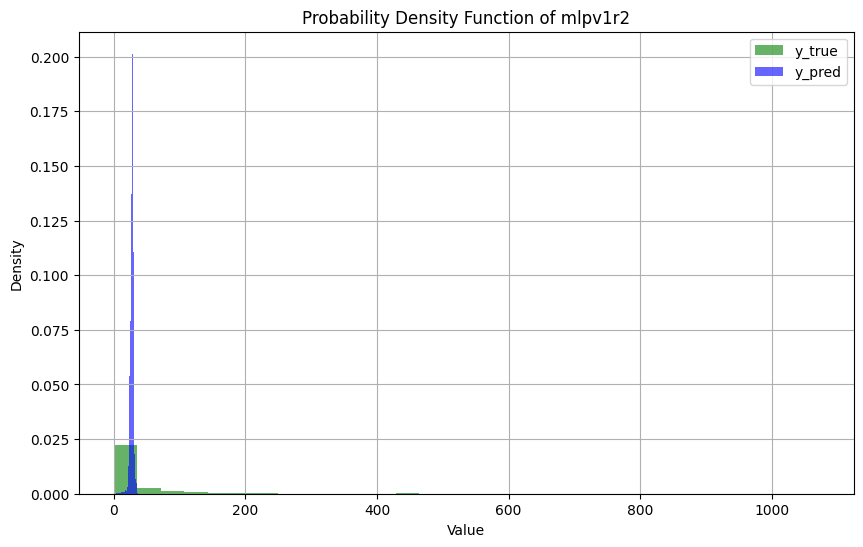

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# This code was generated by Gemini 2.5pro then modified

# Plot the probability density functions
plt.figure(figsize=(10, 6))

# Plot PDF for y_true
plt.hist(y_true, bins=30, density=True, alpha=0.6, color='g', label='y_true')

# Plot PDF for y_pred
plt.hist(y_pred, bins=30, density=True, alpha=0.6, color='b', label='y_pred')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
model_name = model.GetModelFullName()
plt.title(f'Probability Density Function of {model_name}')
plt.savefig(f'{model_name}-pdf-plot.png')

In [ ]:
cmd = "ls -lt model"
os.system(cmd)